# Disable Rounding of some transfers


When transfers are calculated, in some cases intermediate results or the final amount need to be rounded based on German law. As a default, GETTSIM also rounds these results. However, we can disable rounding which is for example beneficial if results are used within a numerical optimization.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from gettsim import set_up_policy_environment
from gettsim import compute_taxes_and_transfers
from gettsim import plot_dag
from gettsim.synthetic_data.synthetic import create_synthetic_data

## Create synthetic data set and set up policy environment

In [2]:
## idea for use of synthetical data 
data = create_synthetic_data(
    hh_typen=["single"], 
     n_children=[0], 
     age_adults=[70], 
    heterogeneous_vars={"bruttolohn_m": np.arange(0, 1000, 1)}
)
data["rentner"] = True
data["entgeltpunkte"] = np.arange(10, 10.1, 0.0001)
data["entgeltp_grundr"] = data["entgeltpunkte"]
data.head()

,index,hh_id,tu_id,p_id,hh_typ,kind,bruttolohn_m,alter,rentner,alleinerziehend,...,m_elterngeld_vat,behinderungsgrad,mietstufe,immobilie_baujahr,vermögen_hh,entgeltpunkte,gr_bewertungszeiten,entgeltp_grundr,grundrentenzeiten,prv_rente_m
0,0,0,0,0,single_0_children,False,0,70,True,False,...,0,0,3,1980,0,10.0000,600,10.0000,600,0.0
1,0,100,100,1,single_0_children,False,1,70,True,False,...,0,0,3,1980,0,10.0001,600,10.0001,600,0.0
2,0,200,200,2,single_0_children,False,2,70,True,False,...,0,0,3,1980,0,10.0002,600,10.0002,600,0.0
3,0,300,300,3,single_0_children,False,3,70,True,False,...,0,0,3,1980,0,10.0003,600,10.0003,600,0.0
4,0,400,400,4,single_0_children,False,4,70,True,False,...,0,0,3,1980,0,10.0004,600,10.0004,600,0.0


In [3]:
# Set up policy environment
policy_params, policy_functions = set_up_policy_environment(date=2021)


## Compute Grundrentenzuschlag and Staatliche Rente including rounding 

(this is the default)

In [4]:
results = compute_taxes_and_transfers(
    data=data,
    params=policy_params,
    targets=["grundr_zuschlag_m", "staatl_rente_m"],
    functions=policy_functions,
)

In [5]:
results

,grundr_zuschlag_m,staatl_rente_m
0,209.41,585.50
1,209.42,585.52
2,209.42,585.54
3,209.42,585.55
4,209.42,585.57
...,...,...
995,211.50,602.14
996,211.50,602.16
997,211.50,602.17
998,211.50,602.19


When zooming in, rounding leads to a step function which is very hard to optimize over.

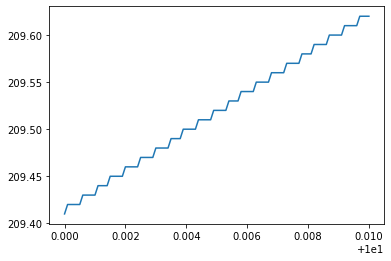

In [6]:
plt.plot("entgeltpunkte", "grundr_zuschlag_m", data=results.join(data).query("entgeltpunkte < 10.01"))

## Disable rounding 

This leads to a smooth relation between `entgeltpunkte` and `grundr_zuschlag_m`

In [7]:
results = compute_taxes_and_transfers(
    data=data,
    params=policy_params,
    targets=["grundr_zuschlag_m", "staatl_rente_m"],
    functions=policy_functions,
    rounding=False
)

In [8]:
results

,grundr_zuschlag_m,staatl_rente_m
0,209.413750,585.503750
1,209.415844,585.520469
2,209.417938,585.537188
3,209.420032,585.553908
4,209.422127,585.570627
...,...,...
995,211.497417,602.139350
996,211.499511,602.156069
997,211.501605,602.172788
998,211.503699,602.189507


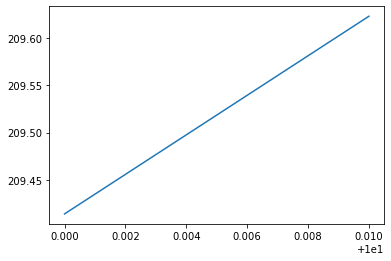

In [9]:
plt.plot("entgeltpunkte", "grundr_zuschlag_m", data=results.join(data).query("entgeltpunkte < 10.01"))

## Implementation

Whether a function should be rounded and in which way, is added to the function as attribute.

In [10]:
from gettsim.transfers.grundrente import grundr_zuschlag_m
grundr_zuschlag_m.__roundingspec__

{'base': 0.01, 'direction': 'nearest'}

To add these attributes to functions you have written yourself (see [policy functions tutorial](policy_functions.ipynb)), you can use the function `add_rounding_spec` as decorator as follows:

In [11]:
from gettsim.shared import add_rounding_spec

@add_rounding_spec(base=0.01, direction="up")
def your_own_function():
    out = 0.2
    return out

your_own_function.__roundingspec__

{'base': 0.01, 'direction': 'up'}

`direction` needs to be one of 'up', 'down', or 'nearest'